In [1]:
import pathlib
import io
import os
import sys
# --- Attempt to import necessary libraries ---
try:
    import pymupdf  # PyMuPDF library
except ImportError:
    print("Error: PyMuPDF (pymupdf) library not found. Please install it: pip install PyMuPDF")
    sys.exit(1)

# --- Main Script Logic ---
def process_pdf_folder(folder_path: str, image_output_folder: str, classification_label: str, image_format: str = 'png', dpi: int = 200) -> list:
    """
    Processes all PDFs in a folder using PyMuPDF, renders pages to images,
    saves images, assigns the provided classification label, and returns the dataset.
    
    Args:
        folder_path: Path to the folder containing PDF files.
        image_output_folder: Path to the folder where generated images will be saved.
        classification_label: The classification label to assign to all pages from this folder.
        image_format: Format for image conversion ('png' recommended).
        dpi: Dots per inch for rendering PDF pages to images. Affects quality and size.

    Returns:
        A list of dictionaries, where each dictionary contains
        'filename', 'image_path', and 'classification'.
    """
    pdf_folder = pathlib.Path(folder_path)
    img_out_folder = pathlib.Path(image_output_folder)

    if not pdf_folder.is_dir():
        print(f"Error: PDF input folder not found at '{folder_path}'")
        return []

    # Create the image output directory if it doesn't exist
    try:
        img_out_folder.mkdir(parents=True, exist_ok=True)
        print(f"Image output directory: {img_out_folder.resolve()}")
    except OSError as e:
        print(f"Error: Could not create image output directory '{img_out_folder}': {e}")
        return []

    classification_data = []
    processed_files = 0
    total_pdfs = len(list(pdf_folder.glob('*.pdf'))) # Count PDFs upfront
    print(f"\nStarting processing in folder: {pdf_folder}. Found {total_pdfs} PDF files. Assigning label: '{classification_label}'")
    print(f"Rendering pages at {dpi} DPI as {image_format.upper()} images.")

    for pdf_path in pdf_folder.glob('*.pdf'):
        print(f"  Processing file: {pdf_path.name} ({processed_files + 1}/{total_pdfs}) for label '{classification_label}'")
        doc = None # Ensure doc is closable in finally block
        try:
            # 1. Open the PDF document
            doc = pymupdf.open(pdf_path)
            num_pages = len(doc)
            print(f"    - Opened '{pdf_path.name}', found {num_pages} pages.")

            # 2. Iterate through each page
            for i in range(num_pages):
                page_num = i + 1
                print(f"    - Processing Page {page_num}/{num_pages}")
                page = doc.load_page(i)  # Load the current page

                # 3. Render page to an image (pixmap)
                zoom = dpi / 72.0
                matrix = pymupdf.Matrix(zoom, zoom)
                pix = page.get_pixmap(matrix=matrix, alpha=False)

                # 4. Define image filename and path
                safe_pdf_name = "".join(c if c.isalnum() or c in ('_','-') else '_' for c in pdf_path.stem)
                image_filename = f"{classification_label}_{safe_pdf_name}_page_{page_num}.{image_format}"
                image_save_path = img_out_folder / image_filename

                try:
                    pix.save(image_save_path)
                    print(f"    - Saved image to: {image_save_path}")
                except Exception as save_err:
                    print(f"    - Error saving image for page {page_num} to {image_save_path}: {save_err}")
                    classification_data.append({
                        'filename': pdf_path.name,
                        'image_path': 'error_saving_image',
                        'classification': 'error_saving_image'
                    })
                    continue # Skip to next page if image saving fails

                # 5. Assign the classification label passed to the function
                classification = classification_label
                print(f"     - Assigned classification: {classification}")

                # 6. Store the result including the image path
                relative_image_path = str(image_save_path.relative_to(img_out_folder.parent))
                classification_data.append({
                    'filename': pdf_path.name,
                    'image_path': relative_image_path,
                    'classification': classification
                })

            processed_files += 1

        except Exception as e:
            print(f"    - An unexpected ERROR occurred while processing file {pdf_path.name}: {e}")
            classification_data.append({
                'filename': pdf_path.name,
                'image_path': 'error_processing_file',
                'classification': 'error_processing_file'
            })
        finally:
            if doc:
                doc.close() # Ensure the PDF file is closed

    print(f"  Finished processing folder {pdf_folder}. Successfully processed {processed_files}/{total_pdfs} PDF files.")
    return classification_data

# --- Example Usage ---
if __name__ == "__main__":
    # Define input PDF folders and output image folder
    pdf_input_folder_single = r"D:\DATA300\AudioBookSum\pdf\single_column"
    pdf_input_folder_multi = r"D:\DATA300\AudioBookSum\pdf\multi_column"
    image_output_folder = r"D:\DATA300\AudioBookSum\output_images"

    # --- Check input folders ---
    pdf_input_folder_single_path = pathlib.Path(pdf_input_folder_single)
    pdf_input_folder_multi_path = pathlib.Path(pdf_input_folder_multi)
    image_output_folder_path = pathlib.Path(image_output_folder)

    folders_ok = True
    if not pdf_input_folder_single_path.is_dir():
         print(f"Error: The specified single-column input folder does not exist: {pdf_input_folder_single}")
         folders_ok = False

    if not pdf_input_folder_multi_path.is_dir():
         print(f"Error: The specified multi-column input folder does not exist: {pdf_input_folder_multi}")
         folders_ok = False

    if not folders_ok:
        sys.exit(1)

    # Create the shared image output directory
    try:
        image_output_folder_path.mkdir(parents=True, exist_ok=True)
        print(f"Ensured image output directory exists: {image_output_folder_path.resolve()}")
    except OSError as e:
        print(f"Error: Could not create image output directory '{image_output_folder_path}': {e}")
        sys.exit(1)

    # --- Run the processing function for each folder ---
    print("--- Starting PDF Processing ---")
    dataset_single = process_pdf_folder(
        folder_path=pdf_input_folder_single,
        image_output_folder=image_output_folder,
        classification_label='singlecolumn',
        image_format='png',
        dpi=150
    )

    dataset_multi = process_pdf_folder(
        folder_path=pdf_input_folder_multi,
        image_output_folder=image_output_folder,
        classification_label='multicolumn',
        image_format='png',
        dpi=150
    )

    # --- Combine datasets ---
    dataset = dataset_single + dataset_multi
    print(f"\n--- Combined Dataset Size: {len(dataset)} entries ---")

    # --- Output the results ---
    if dataset:
        output_csv_file = "document_classifications_with_paths.csv"
        try:
            import csv
            with open(output_csv_file, 'a', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['filename', 'image_path', 'classification']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                if csvfile.tell() == 0:
                    writer.writeheader()
                    print(f"Writing header to new/empty file: {output_csv_file}")

                writer.writerows(dataset)
                print(f"Dataset successfully appended to {output_csv_file}")
        except ImportError:
            print("\nWarning: 'csv' module not found. Cannot save dataset to CSV.")
        except Exception as write_err:
             print(f"\nError saving/appending dataset to CSV '{output_csv_file}': {write_err}")
    else:
        print("No data was generated from either folder. Check logs for errors or ensure PDF files are present.")


Ensured image output directory exists: D:\DATA300\AudioBookSum\output_images
--- Starting PDF Processing ---
Image output directory: D:\DATA300\AudioBookSum\output_images

Starting processing in folder: D:\DATA300\AudioBookSum\pdf\single_column. Found 5 PDF files. Assigning label: 'singlecolumn'
Rendering pages at 150 DPI as PNG images.
  Processing file: 2504.16093v1.pdf (1/5) for label 'singlecolumn'
    - Opened '2504.16093v1.pdf', found 15 pages.
    - Processing Page 1/15
    - Saved image to: D:\DATA300\AudioBookSum\output_images\singlecolumn_2504_16093v1_page_1.png
     - Assigned classification: singlecolumn
    - Processing Page 2/15
    - Saved image to: D:\DATA300\AudioBookSum\output_images\singlecolumn_2504_16093v1_page_2.png
     - Assigned classification: singlecolumn
    - Processing Page 3/15
    - Saved image to: D:\DATA300\AudioBookSum\output_images\singlecolumn_2504_16093v1_page_3.png
     - Assigned classification: singlecolumn
    - Processing Page 4/15
    - Saved

Loaded 2024 entries from D:\DATA300\AudioBookSum\src\document_classifications_with_paths.csv

Processing image 1/2024: 04_29_19_page_1.png (Label: multicolumn)
  Detected 1 final regions for 04_29_19_page_1.png.

Processing image 2/2024: 04_29_19_page_2.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_2.png.

Processing image 3/2024: 04_29_19_page_3.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_3.png.

Processing image 4/2024: 04_29_19_page_4.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_4.png.

Processing image 5/2024: 04_29_19_page_5.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_5.png.

Processing image 6/2024: 04_29_19_page_6.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_6.png.

Processing image 7/2024: 04_29_19_page_7.png (Label: single column)
  Detected 1 final regions for 04_29_19_page_7.png.

Processing image 8/2024: 04_29_19_page_8.png (Label: single c

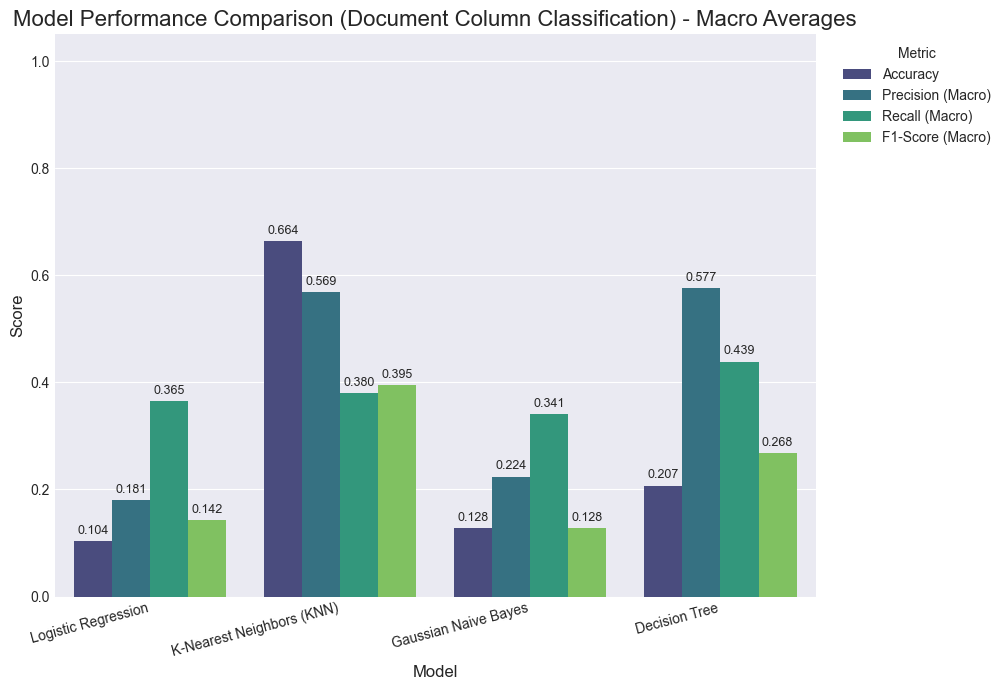

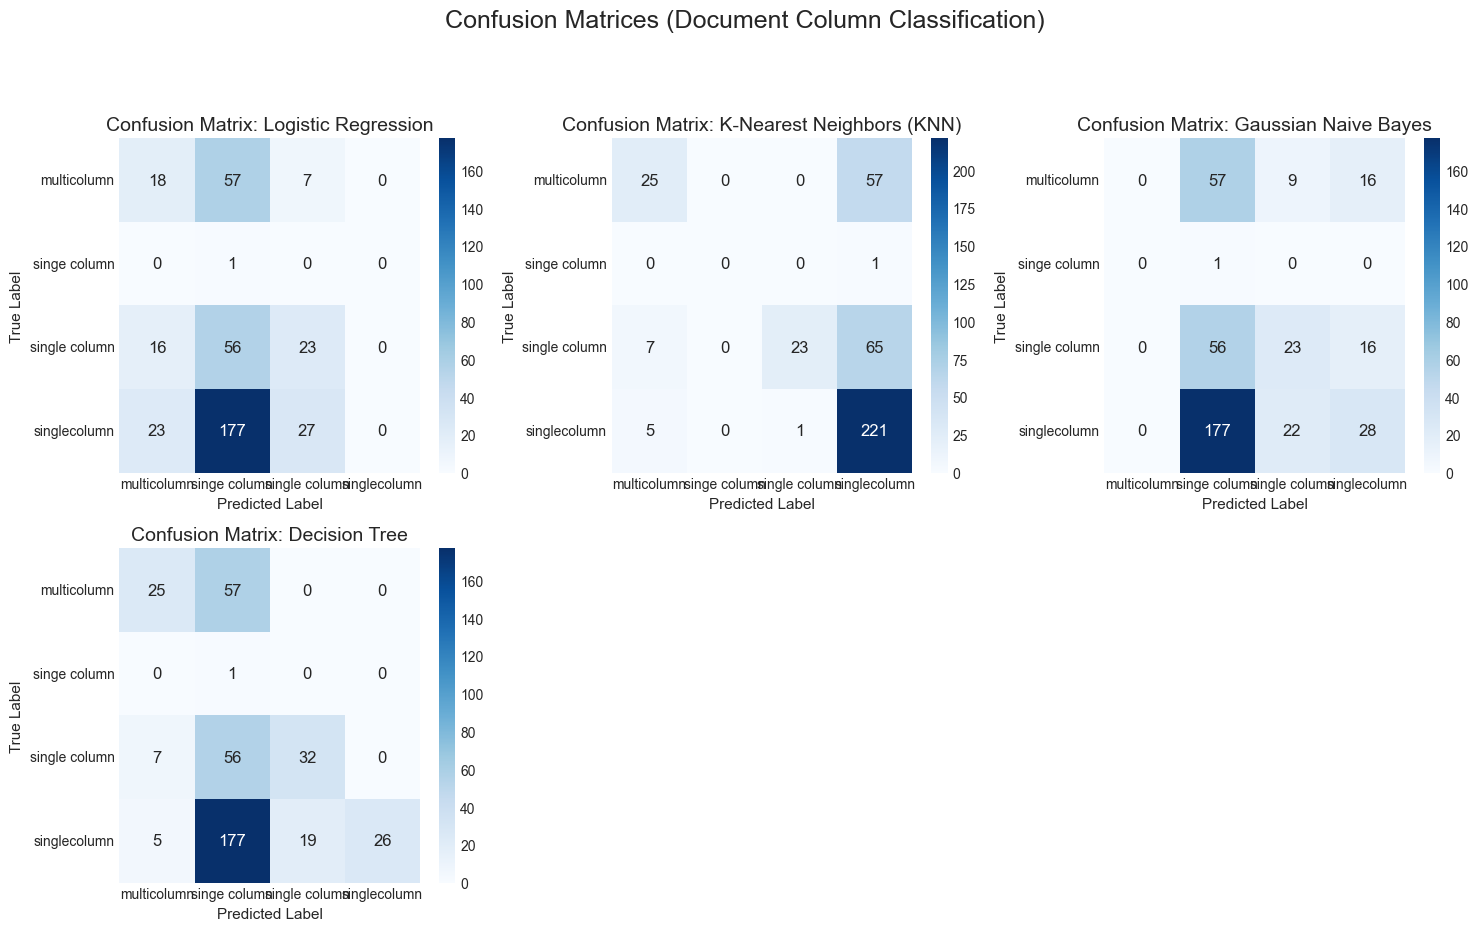


Using 'Logistic Regression' as baseline for comparison.

--- Performance Difference from Baseline (Logistic Regression) ---
                    Model Accuracy Diff Precision (Macro) Diff Recall (Macro) Diff F1-Score (Macro) Diff
K-Nearest Neighbors (KNN)       +0.5605                +0.3884             +0.0147               +0.2531
     Gaussian Naive Bayes       +0.0247                +0.0433             -0.0240               -0.0144
            Decision Tree       +0.1037                +0.3960             +0.0737               +0.1256


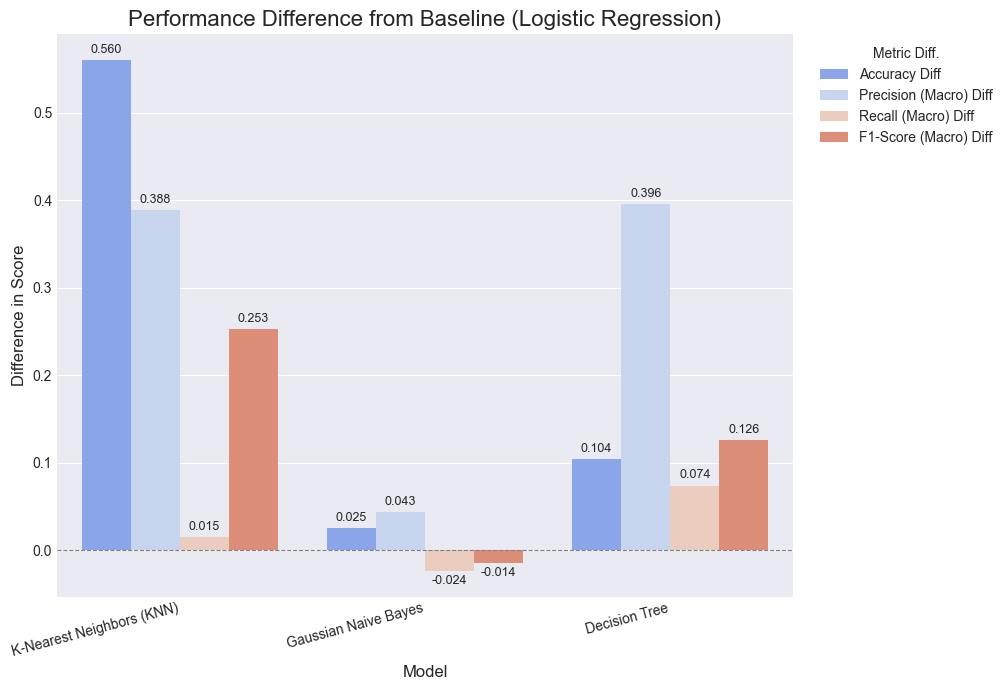


Performance difference analysis complete.


In [5]:
import cv2      # OpenCV
import numpy as np
import os
import pandas as pd
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt # For visual_proof

# --- Machine Learning Imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Assuming features are somewhat Gaussian
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle # Import shuffle
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=RuntimeWarning) # Ignore potential division by zero etc. in numpy if no boxes found

# Type alias for pixel bounding box
PixelBoundingBox = Tuple[int, int, int, int] # (x, y, width, height)
# Import necessary libraries for plotting and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Dict, Any, Optional

# --- Performance Analysis and Visualization Function ---

def analyze_and_visualize_performance(
    results: Dict[str, Dict[str, Any]],
    label_encoder: Optional[Any] = None, # Pass the fitted LabelEncoder
    baseline_model_name: Optional[str] = None, # e.g., "Logistic Regression" or None to auto-select best accuracy
    dataset_name: str = "Dataset" # Optional name for plot titles
):
    """
    Analyzes and visualizes the performance of multiple classification models.

    Generates:
        1. A bar chart comparing Accuracy, Precision, Recall, and F1-score (macro avg).
        2. Plots of confusion matrices for each model.
        3. Calculates and returns performance differences relative to a baseline model.

    Args:
        results: A dictionary where keys are model names and values are dictionaries
                 containing at least 'accuracy', 'report' (classification_report string),
                 'confusion_matrix' (numpy array), and potentially 'model' object.
                 Expected output format from `run_classification_comparison`.
        label_encoder: The fitted scikit-learn LabelEncoder instance used for the target
                       variable, needed for class names in plots. If None, generic
                       labels ('Class 0', 'Class 1') will be used.
        baseline_model_name: The name of the model to use as a baseline for comparison.
                             If None, the model with the highest accuracy will be chosen.
        dataset_name: An optional name for the dataset to include in plot titles.

    Returns:
        pandas.DataFrame: A DataFrame containing the performance differences
                          (Accuracy, Precision, Recall, F1) for each model
                          relative to the baseline. Returns None if analysis fails.
    """
    print("\n--- Performance Analysis and Visualization ---")

    valid_results = {name: res for name, res in results.items() if res and res.get('confusion_matrix') is not None}

    if not valid_results:
        print("No valid model results found to analyze.")
        return None

    model_names = list(valid_results.keys())
    class_names = ['Class 0', 'Class 1'] # Default if label_encoder is not provided
    if label_encoder and hasattr(label_encoder, 'classes_'):
         if len(label_encoder.classes_) == valid_results[model_names[0]]['confusion_matrix'].shape[0]:
              class_names = label_encoder.classes_
         else:
              print("Warning: LabelEncoder classes don't match confusion matrix dimensions. Using generic labels.")


    # --- 1. Extract Key Metrics ---
    metrics_data = {
        'Model': [],
        'Accuracy': [],
        'Precision (Macro)': [],
        'Recall (Macro)': [],
        'F1-Score (Macro)': []
    }

    for name, res in valid_results.items():
        try:
            # Extract metrics from classification report string (more robust than just accuracy)
            report_dict = classification_report(
                y_true=np.array([]), # Dummy y_true/y_pred needed structure, won't be used
                y_pred=np.array([]), # We only parse the string report provided
                output_dict=True,
                zero_division=0,
                labels=np.arange(len(class_names)), # Ensure correct labels are considered
                target_names=class_names,
                # Hack: Pass the report string itself if available (not standard usage)
                # A better way is to recalculate from y_test, y_pred if available
                # For now, we parse the stored string report if possible, otherwise calculate macro avg from CM
                # Let's recalculate if possible (assuming y_test/y_pred were stored or accessible)
                # If not, we parse the string report (less ideal) or calculate from CM
            )

            # Fallback/Alternative: Calculate macro averages directly from confusion matrix
            cm = res['confusion_matrix']
            if cm.shape[0] != cm.shape[1]:
                 print(f"Warning: Non-square confusion matrix for {name}. Skipping metric calculation.")
                 continue

            tp = np.diag(cm)
            fp = cm.sum(axis=0) - tp # Sum down column (predicted positive) - true positives
            fn = cm.sum(axis=1) - tp # Sum across row (actual positive) - true positives
            # tn = cm.sum() - (fp + fn + tp) # Not directly needed for macro precision/recall

            # Per-class precision and recall (handle division by zero)
            precision_per_class = tp / (tp + fp)
            recall_per_class = tp / (tp + fn)
            f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

            # Replace NaNs resulting from division by zero (e.g., class never predicted)
            precision_per_class = np.nan_to_num(precision_per_class)
            recall_per_class = np.nan_to_num(recall_per_class)
            f1_per_class = np.nan_to_num(f1_per_class)

            macro_precision = np.mean(precision_per_class)
            macro_recall = np.mean(recall_per_class)
            macro_f1 = np.mean(f1_per_class) # Macro F1 is average of per-class F1

            metrics_data['Model'].append(name)
            metrics_data['Accuracy'].append(res['accuracy']) # Accuracy is usually overall
            metrics_data['Precision (Macro)'].append(macro_precision)
            metrics_data['Recall (Macro)'].append(macro_recall)
            metrics_data['F1-Score (Macro)'].append(macro_f1)

        except Exception as e:
            print(f"Warning: Could not parse or calculate detailed metrics for {name}. Error: {e}")
            # Add placeholders if parsing fails but accuracy exists
            if 'accuracy' in res:
                 metrics_data['Model'].append(name)
                 metrics_data['Accuracy'].append(res['accuracy'])
                 metrics_data['Precision (Macro)'].append(np.nan)
                 metrics_data['Recall (Macro)'].append(np.nan)
                 metrics_data['F1-Score (Macro)'].append(np.nan)


    metrics_df = pd.DataFrame(metrics_data)
    if metrics_df.empty:
         print("Could not extract metrics for any model.")
         return None

    print("\n--- Comparative Metrics (Macro Averages) ---")
    print(metrics_df.to_string(index=False))

    # --- 2. Plot Key Metrics Comparison ---
    try:
        plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
        metrics_to_plot = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
        plot_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score', value_vars=metrics_to_plot)

        plt.figure(figsize=(12, 7))
        bar_plot = sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric', palette='viridis')

        plt.title(f'Model Performance Comparison ({dataset_name}) - Macro Averages', fontsize=16)
        plt.xlabel("Model", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        plt.xticks(rotation=15, ha='right')
        plt.ylim(0, 1.05) # Scores are typically between 0 and 1
        plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')

        # Add score labels on top of bars
        for container in bar_plot.containers:
            bar_plot.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
    except Exception as e:
        print(f"Error generating metrics comparison plot: {e}")


    # --- 3. Plot Confusion Matrices ---
    num_models = len(valid_results)
    # Adjust layout based on number of models
    ncols = min(num_models, 3) # Max 3 columns
    nrows = (num_models + ncols - 1) // ncols # Calculate rows needed

    if num_models > 0:
        try:
            fig_cm, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4.5), squeeze=False)
            axes = axes.flatten() # Flatten the axes array for easy iteration

            for i, (name, res) in enumerate(valid_results.items()):
                cm = res['confusion_matrix']
                if cm is None:
                    # Optionally plot an empty placeholder or text
                    axes[i].text(0.5, 0.5, 'No CM data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
                    axes[i].set_title(f"{name}\n(No Data)", fontsize=12)
                    axes[i].axis('off')
                    continue

                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                            xticklabels=class_names, yticklabels=class_names,
                            annot_kws={"size": 12}) # Increase annotation font size
                axes[i].set_title(f"Confusion Matrix: {name}", fontsize=14)
                axes[i].set_xlabel("Predicted Label", fontsize=11)
                axes[i].set_ylabel("True Label", fontsize=11)
                axes[i].tick_params(axis='x', rotation=0) # Keep x-axis labels horizontal
                axes[i].tick_params(axis='y', rotation=0)

            # Hide any unused subplots
            for j in range(i + 1, len(axes)):
                fig_cm.delaxes(axes[j])

            fig_cm.suptitle(f'Confusion Matrices ({dataset_name})', fontsize=18, y=1.03) # Add overall title
            plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout for suptitle
            plt.show()
        except Exception as e:
            print(f"Error generating confusion matrix plots: {e}")

    # --- 4. Calculate Performance Differences ---
    if baseline_model_name is None or baseline_model_name not in metrics_df['Model'].values:
        # Auto-select baseline: model with highest accuracy
        baseline_model_name = metrics_df.loc[metrics_df['Accuracy'].idxmax()]['Model'] if not metrics_df.empty else None
        if baseline_model_name:
             print(f"\nUsing '{baseline_model_name}' (highest accuracy) as baseline for comparison.")
        else:
             print("Could not determine baseline model.")
             return None # Cannot calculate differences without a baseline
    elif baseline_model_name not in metrics_df['Model'].values:
         print(f"Error: Specified baseline model '{baseline_model_name}' not found in results. Cannot calculate differences.")
         return None
    else:
         print(f"\nUsing '{baseline_model_name}' as baseline for comparison.")


    baseline_metrics = metrics_df[metrics_df['Model'] == baseline_model_name].iloc[0]
    diff_data = {'Model': []}
    metrics_for_diff = [col for col in metrics_df.columns if col != 'Model'] # Get all metric columns
    for metric in metrics_for_diff:
        diff_data[f'{metric} Diff'] = []

    for i, row in metrics_df.iterrows():
        if row['Model'] == baseline_model_name:
            continue # Skip comparison with self

        diff_data['Model'].append(row['Model'])
        for metric in metrics_for_diff:
             diff = row[metric] - baseline_metrics[metric]
             diff_data[f'{metric} Diff'].append(diff)

    diff_df = pd.DataFrame(diff_data)

    if not diff_df.empty:
        print(f"\n--- Performance Difference from Baseline ({baseline_model_name}) ---")
        # Format the difference columns to show +/- signs explicitly
        for col in diff_df.columns:
             if 'Diff' in col:
                 diff_df[col] = diff_df[col].map('{:+.4f}'.format) # Format with sign and 4 decimal places
        print(diff_df.to_string(index=False))

        # --- Optional: Plot Differences ---
        try:
             plot_diff_df = pd.DataFrame(diff_data) # Use the original numeric diff_data
             plot_diff_df = plot_diff_df.melt(id_vars='Model', var_name='Metric Difference', value_name='Difference')

             plt.figure(figsize=(12, 7))
             diff_bar_plot = sns.barplot(data=plot_diff_df, x='Model', y='Difference', hue='Metric Difference', palette='coolwarm') # Use diverging palette

             plt.title(f'Performance Difference from Baseline ({baseline_model_name})', fontsize=16)
             plt.xlabel("Model", fontsize=12)
             plt.ylabel("Difference in Score", fontsize=12)
             plt.xticks(rotation=15, ha='right')
             plt.axhline(0, color='grey', linewidth=0.8, linestyle='--') # Line at zero difference
             plt.legend(title='Metric Diff.', bbox_to_anchor=(1.02, 1), loc='upper left')

             # Add score labels on top of bars
             for container in diff_bar_plot.containers:
                 diff_bar_plot.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

             plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
             plt.show()
        except Exception as e:
             print(f"Error generating performance difference plot: {e}")

    else:
        print("No models to compare against the baseline.")
        return None # Return None if diff_df is empty

    # Return the numeric difference dataframe (before formatting for printing)
    return pd.DataFrame(diff_data)
# --- Bounding Box Merging (Pixel Coordinates) ---
def merge_pixel_regions(boxes: List[PixelBoundingBox],
                         overlap_threshold: float = 0.1, # Min intersection/smaller_area ratio
                         iterations: int = 3) -> List[PixelBoundingBox]:
    """
    Merges overlapping or very close bounding boxes iteratively.
    Operates on (x, y, w, h) tuples.
    """
    if len(boxes) <= 1:
        return boxes

    current_boxes = list(boxes)
    for _ in range(iterations):
        merged_in_pass = False
        merged_boxes = []
        used = [False] * len(current_boxes)

        # Sort boxes to potentially improve efficiency (top-to-bottom, left-to-right)
        current_boxes.sort(key=lambda b: (b[1], b[0]))

        for i in range(len(current_boxes)):
            if used[i]:
                continue

            base_box = list(current_boxes[i]) # Use list for modification
            base_x, base_y, base_w, base_h = base_box
            base_x1, base_y1 = base_x + base_w, base_y + base_h
            base_area = base_w * base_h

            used[i] = True
            did_merge = True # Flag to check if this specific box merged with others

            while did_merge: # Keep merging with the current base_box until no more overlaps found
                 did_merge = False
                 for j in range(i + 1, len(current_boxes)):
                    if not used[j]:
                        other_box = current_boxes[j]
                        other_x, other_y, other_w, other_h = other_box
                        other_x1, other_y1 = other_x + other_w, other_y + other_h
                        other_area = other_w * other_h

                        # Check for overlap (intersection)
                        inter_x0 = max(base_x, other_x)
                        inter_y0 = max(base_y, other_y)
                        inter_x1 = min(base_x1, other_x1)
                        inter_y1 = min(base_y1, other_y1)

                        inter_w = inter_x1 - inter_x0
                        inter_h = inter_y1 - inter_y0

                        if inter_w > 0 and inter_h > 0: # They overlap
                            intersection_area = inter_w * inter_h
                            smaller_area = min(base_area, other_area) if min(base_area, other_area) > 0 else 1e-6

                            # Merge if intersection area is significant relative to smaller box
                            if intersection_area / smaller_area >= overlap_threshold:
                                # Calculate union box
                                union_x0 = min(base_x, other_x)
                                union_y0 = min(base_y, other_y)
                                union_x1 = max(base_x1, other_x1)
                                union_y1 = max(base_y1, other_y1)

                                # Update base_box to the union
                                base_box = [union_x0, union_y0, union_x1 - union_x0, union_y1 - union_y0]
                                base_x, base_y, base_w, base_h = base_box # Update values for next check
                                base_x1, base_y1 = base_x + base_w, base_y + base_h
                                base_area = base_w * base_h

                                used[j] = True
                                merged_in_pass = True
                                did_merge = True # Mark that this base_box grew
                                # Continue checking other boxes against the *new* larger base_box

                 # End of inner loop (checking against other boxes)
                 # If did_merge is True here, the while loop repeats for the current base_box

            merged_boxes.append(tuple(base_box)) # Add the final merged box for index i

        current_boxes = merged_boxes
        if not merged_in_pass: # If no merges happened in a full pass, stop early
            break

    return current_boxes


# --- Contour/Region Extraction from Image ---
def extract_regions_from_image(
    image_path: str,
    adaptive_thresh_block_size: int = 15, # Must be odd > 1 - Adjusted for potentially different image characteristics
    adaptive_thresh_c: int = 2,         # Adjusted C
    morph_kernel_size: tuple = (8, 8), # Rectangular kernel might be better for text lines
    dilate_iterations: int = 2,         # More dilation might be needed
    min_region_width_px: int = 8,      # Min width in pixels
    min_region_height_px: int = 8,     # Min height in pixels
    merge_iterations: int = 3,
    visual_proof: bool = False
) -> Tuple[List[PixelBoundingBox], int, int]:
    """
    Extracts bounding boxes of text-like regions directly from an image file using OpenCV.

    Args:
        image_path: Path to the input PNG image.
        ... (other parameters for OpenCV processing) ...
        visual_proof: If True, displays intermediate images.

    Returns:
        A tuple containing:
        - List of bounding boxes [(x, y, w, h), ...] in pixel coordinates.
        - Image width in pixels.
        - Image height in pixels.
        Returns ([], 0, 0) on failure.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"  Error: Could not read image {image_path}")
            return [], 0, 0
        img_h, img_w = img.shape[:2]
    except Exception as e:
        print(f"  Error loading image {image_path}: {e}")
        return [], 0, 0

    # 1. Preprocessing
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif len(img.shape) == 2:
        gray = img
    else:
        print(f"  Error: Unsupported image shape {img.shape} for {image_path}")
        return [], img_w, img_h # Return dims even on failure?

    # Invert: Assume dark text on light background common in documents
    # Process expects white features on black background
    gray_inverted = cv2.bitwise_not(gray)

    # 2. Adaptive Thresholding
    adaptive = cv2.adaptiveThreshold(gray_inverted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, adaptive_thresh_block_size, adaptive_thresh_c)

    # 3. Morphological Operations
    # Use a kernel more suited for joining characters into lines/blocks
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_size)
    dilated = cv2.dilate(adaptive, rectKernel, iterations=dilate_iterations)

    # Optional: Closing (can sometimes merge distinct columns if kernel/iterations are too large)
    # Use a smaller kernel for closing if needed
    # closeKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, closeKernel, iterations=1)
    # target_image_for_contours = closed
    target_image_for_contours = dilated # Use dilated for now

    # 4. Find Contours
    contours, _ = cv2.findContours(target_image_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(f"  Found {len(contours)} initial contours.") # Debug

    # 5. Create Initial Regions (Pixel BBoxes) & Pre-filter
    initial_regions = []
    if contours is None:
        contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Basic filtering based on size
        if w >= min_region_width_px / 2 and h >= min_region_height_px / 2: # Looser filter before merge
            initial_regions.append((x, y, w, h))

    # print(f"  Created {len(initial_regions)} initial regions after pre-filtering.") # Debug

    # 6. Merge Overlapping/Nearby Regions
    merged_regions = merge_pixel_regions(initial_regions, iterations=merge_iterations)

    # 7. Final Filtering
    final_regions = [r for r in merged_regions
                     if r[2] >= min_region_width_px and r[3] >= min_region_height_px]

    # Sort final regions by approx reading order (top-to-bottom, left-to-right)
    final_regions.sort(key=lambda r: (r[1], r[0]))

    print(f"  Detected {len(final_regions)} final regions for {os.path.basename(image_path)}.")

    # --- Optional Visual Proof ---
    if visual_proof:
        try:
            viz_img = img.copy()
            # Draw intermediate steps if needed
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 3, 1)
            plt.imshow(adaptive, cmap='gray')
            plt.title("Thresholded")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(target_image_for_contours, cmap='gray')
            plt.title("Dilated/Closed")
            plt.axis('off')

            # Draw final detected regions on original image
            for (x, y, w, h) in final_regions:
                cv2.rectangle(viz_img, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green boxes

            plt.subplot(1, 3, 3)
            # Convert BGR (OpenCV) to RGB (matplotlib)
            plt.imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Detected Regions ({len(final_regions)} blocks)")
            plt.axis('off')

            plt.suptitle(f"Processing: {os.path.basename(image_path)}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
            plt.show()
        except Exception as e:
            print(f"  Error generating visual proof: {e}")

    return final_regions, img_w, img_h


# --- Feature Engineering (from Pixel Boxes) ---
def extract_features_from_pixel_boxes(boxes: List[PixelBoundingBox], img_width: int, img_height: int) -> Dict[str, float]:
    """
    Calculates features based on the list of detected pixel bounding boxes (x, y, w, h).
    """
    features = {
        'num_blocks': 0.0,
        'median_width': 0.0,
        'std_width': 0.0,
        'median_height': 0.0,
        'std_height': 0.0,
        'median_x_center': 0.0,
        'std_x_center': 0.0,
        'median_y_center': 0.0,
        'std_y_center': 0.0,
        'total_width_ratio': 0.0, 
        'median_aspect_ratio': 0.0,
        'norm_median_width': 0.0,
        'norm_std_x_center': 0.0,
    }

    if not boxes or img_width <= 0 or img_height <= 0:
        return features

    widths = [float(b[2]) for b in boxes]
    heights = [float(b[3]) for b in boxes]
    x_centers = [float(b[0]) + float(b[2]) / 2.0 for b in boxes]
    y_centers = [float(b[1]) + float(b[3]) / 2.0 for b in boxes]
    aspect_ratios = [float(b[2]) / float(b[3]) if b[3] > 0 else 0 for b in boxes]

    features['num_blocks'] = float(len(boxes))
    features['median_width'] = np.median(widths) if widths else 0.0
    features['std_width'] = np.std(widths) if widths else 0.0
    features['median_height'] = np.median(heights) if heights else 0.0
    features['std_height'] = np.std(heights) if heights else 0.0
    features['median_x_center'] = np.median(x_centers) if x_centers else 0.0
    features['std_x_center'] = np.std(x_centers) if x_centers else 0.0
    features['median_y_center'] = np.median(y_centers) if y_centers else 0.0
    features['std_y_center'] = np.std(y_centers) if y_centers else 0.0
    features['total_width_ratio'] = sum(widths) / float(img_width) if img_width > 0 else 0.0
    features['median_aspect_ratio'] = np.median(aspect_ratios) if aspect_ratios else 0.0

    # Normalized features
    features['norm_median_width'] = features['median_width'] / float(img_width) if img_width > 0 else 0.0
    features['norm_std_x_center'] = features['std_x_center'] / float(img_width) if img_width > 0 else 0.0

    return features

# --- Data Loading and Processing from CSV ---
def load_and_process_images_from_csv(csv_path: str, image_path_col: str, label_col: str, visualize_index: int = -1) -> pd.DataFrame:
    """
    Loads image paths and labels from a CSV, extracts regions, calculates features,
    and returns a DataFrame.

    Args:
        csv_path: Path to the CSV file.
        image_path_col: Name of the column containing image paths.
        label_col: Name of the column containing labels.
        visualize_index: Row index (0-based) in the CSV to visualize processing for.

    Returns:
        A pandas DataFrame with features and labels. Returns empty DataFrame on error.
    """
    try:
        df_input = pd.read_csv(csv_path)
        if image_path_col not in df_input.columns or label_col not in df_input.columns:
             print(f"Error: CSV must contain columns named '{image_path_col}' and '{label_col}'")
             return pd.DataFrame()
        print(f"Loaded {len(df_input)} entries from {csv_path}")
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error reading CSV {csv_path}: {e}")
        return pd.DataFrame()

    all_features = []
    base_dir = os.path.dirname(csv_path) # Assume relative paths are relative to the CSV

    for index, row in df_input.iterrows():
        image_file = row[image_path_col]
        label = row[label_col]

        # Construct full path (handle relative paths)
        if not os.path.isabs(image_file):
             image_path = os.path.join(base_dir, image_file)
        else:
             image_path = image_file

        print(f"\nProcessing image {index+1}/{len(df_input)}: {os.path.basename(image_path)} (Label: {label})")

        if not os.path.exists(image_path):
             print(f"  Warning: Image file not found at {image_path}. Skipping.")
             continue

        show_visual = (index == visualize_index)

        # Extract regions (bounding boxes) and image dimensions
        boxes, img_w, img_h = extract_regions_from_image(image_path, visual_proof=show_visual)

        if img_w == 0 or img_h == 0:
             print(f"  Warning: Could not get valid dimensions for {image_path}. Skipping feature extraction.")
             continue

        # Calculate features from the detected boxes
        page_features = extract_features_from_pixel_boxes(boxes, img_w, img_h)

        # Add metadata
        page_features['image_path'] = image_file # Store original path from CSV
        page_features['label'] = label
        all_features.append(page_features)

    return pd.DataFrame(all_features)


# --- Main Machine Learning Pipeline (Mostly Unchanged) ---
def run_classification_comparison(data_df: pd.DataFrame):
    """
    Trains and evaluates the four specified classifiers.
    """
    if data_df.empty or 'label' not in data_df.columns:
        print("Feature DataFrame is empty or missing 'label' column. Cannot train models.")
        return None

    if data_df['label'].nunique() < 2:
        print(f"Error: Only found {data_df['label'].nunique()} unique labels. Need at least 2 for classification.")
        return None

    # --- Shuffle the data ---
    # Shuffle the DataFrame rows randomly before splitting.
    # Using random_state ensures reproducibility if needed.
    data_df_shuffled = shuffle(data_df, random_state=42)
    print("\nData shuffled before splitting.")

    # Prepare data for Scikit-learn using the shuffled DataFrame
    feature_cols = [col for col in data_df_shuffled.columns if col not in ['image_path', 'label']]
    X = data_df_shuffled[feature_cols].copy()
    y_raw = data_df_shuffled['label']

    # Handle potential NaN/inf values resulting from feature extraction
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0.0, inplace=True) # Simple imputation: fill NaNs with 0 (consider alternatives like median)

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print(f"\nLabels mapped: {label_mapping}")

    # Check if enough samples for stratified split
    min_samples_per_class = np.min(np.bincount(y))
    test_size = 0.2
    n_splits = int(1 / test_size) if test_size > 0 else 1

    if min_samples_per_class < n_splits and min_samples_per_class > 0:
         print(f"\nWarning: The smallest class has only {min_samples_per_class} samples.")
         print(f"Adjusting test_size for stratification or consider getting more data.")
         # Adjust test size if possible, or don't stratify
         if min_samples_per_class <= 1:
             print("Cannot stratify with only 1 sample in a class. Splitting without stratify.")
             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=None)
         else:
             # Try reducing test size to keep at least 1 sample in test set for each class
             new_test_size = 1.0 / min_samples_per_class if min_samples_per_class > 1 else 0.1 # Ensure test has at least one
             test_size = max(0.1, min(test_size, new_test_size - 0.01)) # Keep at least 10% test, don't make it too big
             print(f"Using adjusted test_size: {test_size:.2f}")
             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    elif min_samples_per_class == 0:
         print("Error: A class has zero samples after potential filtering. Cannot train.")
         return None
    else:
         # Standard split
         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)


    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")


    # Scale features (important for LogReg, KNN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'), # Added balanced weights
        "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5), # K=5 is a common default
        "Gaussian Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced') # Added balanced weights
    }

    results = {}

    # Train and evaluate each model
    print("\n--- Model Training and Evaluation ---")
    for name, model in models.items():
        print(f"\nTraining {name}...")
        # Use scaled data for consistency (NB/DT less sensitive, but won't hurt)
        try:
             model.fit(X_train_scaled, y_train)
             y_pred = model.predict(X_test_scaled)
             y_pred_proba = None
             if hasattr(model, "predict_proba"):
                 y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability for positive class

             accuracy = accuracy_score(y_test, y_pred)
             report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
             cm = confusion_matrix(y_test, y_pred)

             results[name] = {'accuracy': accuracy, 'report': report, 'confusion_matrix': cm, 'model': model}

             print(f"\n--- {name} Results ---")
             print(f"Accuracy: {accuracy:.4f}")
             print("Classification Report:")
             print(report)
             print("Confusion Matrix:")
             print(f"{le.classes_[0]} {le.classes_[1]}") # Show labels for CM axes
             print(cm)
             print("-" * (len(name) + 14)) # Separator

        except Exception as e:
             print(f"  ERROR training or evaluating {name}: {e}")
             results[name] = {'accuracy': 0.0, 'report': 'Error', 'confusion_matrix': None, 'model': None}


    return results, le, scaler # Return label encoder and scaler for potential future use

# --- Example Usage ---
if __name__ == "__main__":
    # --- Configuration ---
    # IMPORTANT: Set the path to your CSV file
    CSV_FILE_PATH = r"D:\DATA300\AudioBookSum\src\document_classifications_with_paths.csv" # <--- UPDATE THIS

    # IMPORTANT: Set the names of the columns in your CSV
    IMAGE_PATH_COLUMN = "image_path" # Column with paths to PNGs
    LABEL_COLUMN = "classification"       # Column with 'single_column' or 'multi_column'

    # Set to a row index (e.g., 0, 1, 2...) to visualize processing for that specific image entry in the CSV.
    # Set to -1 to disable visualization.
    VISUALIZE_ROW_INDEX = -1 # e.g., set to 0 to visualize the first image in the CSV

    # --- Run the process ---
    # 1. Load Images from CSV and Extract Features
    feature_data = load_and_process_images_from_csv(
        csv_path=CSV_FILE_PATH,
        image_path_col=IMAGE_PATH_COLUMN,
        label_col=LABEL_COLUMN,
        visualize_index=VISUALIZE_ROW_INDEX
    )

    # Save features (optional)
    if not feature_data.empty:
         try:
             output_feature_csv = "image_layout_features.csv"
             feature_data.to_csv(output_feature_csv, index=False)
             print(f"\nFeatures saved to {output_feature_csv}")
         except Exception as e:
             print(f"Error saving features to CSV: {e}")


         # 2. Run ML Comparison
         ml_results, label_encoder, feature_scaler = run_classification_comparison(feature_data)

         # Optional: Analyze results further or save models if needed
         if ml_results:
              print("\nClassification comparison complete.")
              # Example: Find best model by accuracy
              best_model_name = max(ml_results, key=lambda k: ml_results[k]['accuracy'] if ml_results[k] else 0.0)
              if ml_results[best_model_name] and ml_results[best_model_name]['accuracy'] > 0:
                  print(f"Best model based on Accuracy: {best_model_name} ({ml_results[best_model_name]['accuracy']:.4f})")
              else:
                  print("Could not determine best model due to errors or zero accuracy.")
         else:
              print("\nClassification comparison could not be completed.")

    else:
         print("\nNo features were extracted from the images. Cannot proceed with classification.")
         print(f"Please check the CSV file path ('{CSV_FILE_PATH}'), column names, image paths within the CSV, and image file integrity.")

    
    # --- Call the analysis function ---
    performance_differences = analyze_and_visualize_performance(
        results=ml_results,
        label_encoder=label_encoder,
        baseline_model_name="Logistic Regression",
        dataset_name= "Document Column Classification"
    )

    if performance_differences is not None:
        print("\nPerformance difference analysis complete.")
        # You can use the returned 'performance_differences' DataFrame further if needed
    else:
        print("\nPerformance difference analysis failed.")